In [ ]:
pip install tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import math
from tensorflow import keras
from PIL import Image
import PIL 
import sys
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from pathlib import Path
from IPython.display import clear_output

In [2]:
from platform import python_version

print(python_version())
print(keras.__version__)
print(tf.__version__)

3.7.13
2.9.0
2.9.2


In [3]:
!nvidia-smi

Tue Jan 10 17:08:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   22C    P8     7W / 250W |      6MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   

In [ ]:
pip install tensorflow==2.9.2

In [ ]:
pip install tensorflow-gpu 
pip install tf-nightly

In [ ]:
tf.test.gpu_device_name()

In [4]:
strategy = tf.distribute.MirroredStrategy(['/GPU:1', '/GPU:2', '/GPU:3', '/GPU:4'], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2023-01-10 17:10:02.695799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 17:10:11.118493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10410 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-01-10 17:10:11.122086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
2023-01-10 17:10:11.127001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/t

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of devices: 4


In [5]:
pip install huggingface-hub

Note: you may need to restart the kernel to use updated packages.


In [6]:
import layers
import modelos
import utils
from layers import BilinearUpSampling2D


In [8]:
dataset_dir = r'/data/estudiantes/juansoto/train_data'
d_map_dir = r'/data/estudiantes/juansoto/D_maps'
# dataset_dir = r'/content/drive/MyDrive/Trabajo_de_Grado_PUJ/KITTI/Codigo/VO_Juan/s_dest'
model_dir = r'/data/estudiantes/juansoto/Check_m6_D1_10'
model_name = 'model_Res'
type_calc = None

batch_size = 16

1.0
0.043137256
(128, 416, 3)


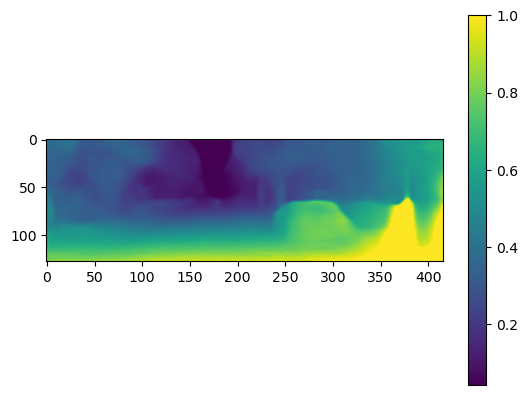

In [9]:
img = Image.open('/data/estudiantes/juansoto/D_maps/00_000000.png')
img = tf.keras.preprocessing.image.img_to_array(img) / 255
#img = mpimg.imread('/data/estudiantes/juansoto/d_maps/00_000000.png')
print(img.max())
print(img.min())
print(img.shape)
imgplot = plt.imshow(img[:,:,0])
plt.colorbar()
plt.show()

255.0
4.0
(128, 768, 3)


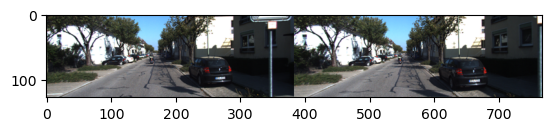

In [10]:
img = Image.open('/data/estudiantes/juansoto/train_data/00_000000.png')
img = tf.keras.preprocessing.image.img_to_array(img) 
#img = mpimg.imread('/data/estudiantes/juansoto/d_maps/00_000000.png')
print(img.max())
print(img.min())
print(img.shape)
imgplot = plt.imshow(img/255)
plt.show()

In [11]:
train_list = utils.text_to_list('/data/estudiantes/juansoto/train_data/train_set_list.txt')

valid_list = utils.text_to_list('/data/estudiantes/juansoto/train_data/valid_set_list.txt')
# count = 0


# create_folder(dir_folder, train_folder, train_list)
# create_folder(dir_folder, valid_folder, valid_list)


In [13]:
def batch_generator_tf(root_path,d_maps_path, files):
    root_path = root_path.decode("utf-8")
    d_maps_path = d_maps_path.decode("utf-8")
    files = files.decode("utf-8")
    
    test = True
    files_list = utils.text_to_list(os.path.join(root_path, files))
    len_file = len(files_list)

    print('Creating batches...')
    for file in files_list:
        # print(file)
        file = file.strip()
        stack, d_map = unpack_images_tf(root_path,d_maps_path,  file)
        # print(f'Motion Vector: {targets.shape}')
        # print(targets)
        # print('###### Reshaping ######')
        
      
        yield (stack, d_map) ### ()
    
def unpack_images_tf(root_path,d_maps_path, filename):
    # names_list = text_to_list(os.path.join(root_path, names_list))
    # print(names_list)
    i = 0
    j = 0

    #print(root_path, names)
    path_file = os.path.join(root_path, filename)
    #path_file = os.path.join(path_file)
    img_ex = Image.open(path_file)
    img_ex = tf.keras.preprocessing.image.img_to_array(img_ex)
    img_ex = tf.image.adjust_brightness(img_ex, delta=0.3)
    
    path_map = os.path.join(d_maps_path, filename)
    #path_map = os.path.join(path_map)
    img_dm = Image.open(path_map)
    img_dm = tf.keras.preprocessing.image.img_to_array(img_dm) / 255
    img_dmp = tf.expand_dims(img_dm[:,:,0], axis = -1)
    
    #if img_ex.shape[0] != 204:
     # img_ex = tf.image.resize(img_ex, (204,204*2), method=tf.image.ResizeMethod.BILINEAR)
    
    
    img_dmp = tf.image.resize(img_dmp, (img_ex.shape[0],img_ex.shape[1]//2), method=tf.image.ResizeMethod.BILINEAR)
    
    tgt_start_idx = int(img_ex.shape[1] // 2)
    tgt_image = tf.concat([img_ex[:, :tgt_start_idx, :], img_ex[:, tgt_start_idx:, :]], axis=2)
    # print(f'Stacked image: {tgt_image.shape}')
    return tgt_image, img_dmp

In [14]:
train_calls = [dataset_dir, d_map_dir, 'train_set_list.txt']
val_calls = [dataset_dir, d_map_dir, 'valid_set_list.txt']

expected_shapes = (128, 384, 6), (128, 384,1)

train_gen = tf.data.Dataset.from_generator(batch_generator_tf, args=train_calls, output_types= (tf.float32, tf.float32), output_shapes= (expected_shapes))
val_gen = tf.data.Dataset.from_generator(batch_generator_tf, args=val_calls, output_types= (tf.float32, tf.float32), output_shapes= (expected_shapes))

train_gen = train_gen.batch(batch_size)
val_gen = val_gen.batch(batch_size)

## Projective

## Model

In [15]:
# depth_model = utils.depth_model()

In [16]:
def get_img_rec(img, M):
    d_map = utils.infer_depth(depth_model,img)
    im2r = proj_custom_f(img, d_map, M)
  
    return im2r

def get_model_2(img_shape):
    inputs = keras.Input(shape=img_shape)
    output = modelos.custom_Res_2(inputs)
    
    if inputs.shape[0] == None:
        imr = inputs[:,:,:,0]
    else:
        imr = get_img_rec(inputs[:,:,:,:3], output)
    
    model = tf.keras.Model(inputs=inputs, outputs=[output, imr])
    
    return model

In [17]:
def crop_batch(img, pixels = 10):
  
  h = img.shape[1]
  w = img.shape[2]


  im1 = tf.image.crop_and_resize(img,boxes=[[pixels/w, pixels/h,(w - pixels)/w , (h - pixels)/h]], crop_size=[h, w], box_indices=[0])

  return im1

# def border_crop(img):
#   mask = np.ones((img.shape[0],204,204,3), dtype=np.float32)
#   mask[:,0:153,51:153,:] = 0
#   mask = tf.convert_to_tensor(mask)
#   masked = tf.multiply(im1, mask)
#   return masked
def border_crop(img):
  if len(img.shape)<4:
    img = tf.expand_dims(im1, axis = 0)

  boxes = tf.convert_to_tensor([[0,0,0.25,0.25], [0,0.75,0.25, 1.0],
                                [0.25,0,0.5,0.25], [0.25,0.75,0.5,1.0],
                                [0.5,0,0.75,0.25], [0.5,0.75,0.75,1.0],
                                [0.75,0,1.0,0.25], [0.75,0.25,1.0,0.5], [0.75,0.5,1.0,0.75], [0.75,0.75,1.0,1.0]
                                ], dtype=tf.float32)

  box_indices = tf.convert_to_tensor([0,0,0,0,0,0,0,0,0,0], dtype=tf.int32)

  output = tf.image.crop_and_resize(img, boxes, box_indices, (32,96))
  return output 

In [18]:
def  create_model():
    model = modelos.custom_Res_06((128, 384, 6))
    return model

In [19]:
with strategy.scope():
    #loss_obj = tf.keras.losses.MeanAbsoluteError(reduction = tf.keras.losses.Reduction.NONE)
    loss_obj = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
    #depth_model = utils.depth_model()
   
    def compute_loss_b(im2, im1,d_map, predictions):
        k = 5
        #d_map = utils.infer_depth(depth_model,im1)
        imr = utils.proj_test(im1, d_map, predictions)
        def inner_loss(imr, im2):
          imr = border_crop(crop_batch(imr, 15))* k
          im2 = border_crop(crop_batch(im2, 15))* k
          per_example_loss = loss_obj(imr, im2)
          return tf.nn.compute_average_loss(per_example_loss, global_batch_size= batch_size * strategy.num_replicas_in_sync)
        return inner_loss(imr, im2), imr
    

    def compute_loss(im2, im1,d_map, predictions):
        #d_map = utils.infer_depth(depth_model,im1)
        imr = utils.proj_test(im1, d_map, predictions)
        def inner_loss(imr, im2):
          per_example_loss = loss_obj(crop_batch(imr, 15), crop_batch(im2, 15))
          return tf.nn.compute_average_loss(per_example_loss, global_batch_size= batch_size * strategy.num_replicas_in_sync)
        return inner_loss(imr, im2), imr
            
    
    loss_map = keras.metrics.MeanAbsoluteError(name='train_loss')
    val_loss =  keras.metrics.MeanAbsoluteError(name='test_loss')
#     optimizer = keras.optimizers.Adam(learning_rate= 0.000005) # Con MAE
    lr = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate= lr)
    metrics = keras.metrics.MeanAbsoluteError()
    val_metrics = keras.metrics.MeanAbsoluteError()
    model = create_model()
    #model.summary()
    #model.load_weights('/data/estudiantes/juansoto/Check_16_11m02/weights-01-0.1049nip.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [20]:
#optimizer.learning_rate
#optimizer.learning_rate = lr/2
optimizer.learning_rate

MirroredVariable:{
  0: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>,
  1: <tf.Variable 'learning_rate/replica_1:0' shape=() dtype=float32, numpy=1e-04>,
  2: <tf.Variable 'learning_rate/replica_2:0' shape=() dtype=float32, numpy=1e-04>,
  3: <tf.Variable 'learning_rate/replica_3:0' shape=() dtype=float32, numpy=1e-04>
}

In [21]:
#loss_obj = tf.keras.losses.MeanAbsoluteError()
# loss_obj = tf.keras.losses.MeanSquaredError()
# def compute_loss(im2, im1, predictions):
#     d_map = utils.infer_depth(depth_model,im1)
#     imr = utils.proj_test(im1, d_map, predictions)
#     def inner_loss(imr, im2):
#       loss = loss_obj(im2*10, imr*10)
#       return loss
#     return inner_loss(imr, im2), imr


In [22]:
# loss_map = keras.metrics.MeanAbsoluteError(n|ame='train_loss')
# val_loss =  keras.metrics.MeanAbsoluteError(name='test_loss')
# optimizer = keras.optimizers.Adam(learning_rate=0.00001)
# #metrics = keras.metrics.MeanAbsoluteError()
# val_metrics = keras.metrics.MeanAbsoluteError()

In [23]:
def img_display(epoch,batch, loss, im1,im2, d_map, predictions, training=True, checking = False):
  clear_output(wait=True)
  #d_map = tf.constant(utils.infer_depth(depth_model,im1), dtype=tf.float32)
  rec = utils.proj_test(im1, d_map, predictions) 
  h = im1.shape[1]
  w = im1.shape[2]

  im1 = crop_batch(im1, 15)
  im2 = crop_batch(im2, 15)
  d_map = crop_batch(d_map, 15)
  rec = crop_batch(rec, 15)
  
  f, axarr = plt.subplots(1,4, figsize=(18,12))
  axarr[0].imshow(im1[0,:,:,:])
  axarr[0].text(w//2, h + 60, '(a)', fontsize=10)
  axarr[1].imshow(d_map[0,:,:,0])
  axarr[1].text(w//2, h + 60, '(b)', fontsize=10)
  axarr[2].imshow(rec[0,:,:,:])
  axarr[2].text(w//2, h + 60, '(c)', fontsize=10)
  if training:
    name = f'fig_e{epoch:02d}_b{batch:02d}_{loss:.4f}.png'
    axarr[1].text(w//4, h + 100, f'EPOCH: {epoch:02d} Batch: {batch:02d} Loss: {loss:.4f}', style='italic', fontsize=15)
  elif not training and not checking:
    name = f'valid_e{epoch:02d}_b{batch:02d}_{loss:.4f}.png'
    axarr[1].text(w//4, h + 100, f'VAL EPOCH: {epoch:02d} Batch: {batch:02d} Loss: {loss:.4f}', style='italic', fontsize=15)
  elif not training and checking:
    name = f'Check_i{batch}_{loss:.4f}.png'
    axarr[1].text(w//4, h + 100, f'Test:  {batch} Loss: {loss:.4f}', style='italic', fontsize=15)
  
  axarr[3].imshow(im2[0,:,:,:])
  axarr[3].text(w//2, h + 60, '(d)', fontsize=10)

  fname = os.path.join(model_dir,name)
  if not checking:
    if epoch == 1 or epoch % 20 == 0:
      plt.savefig(fname)
  else:
    if batch == 1 or batch % 20 == 0:
      plt.savefig(fname)
  plt.show()
  time.sleep(3)
  plt.close()

In [24]:
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args = (dataset_inputs,))

    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis = None)

def train_step(inputs):
    images, d_map = inputs
    #labels = tf.squeeze(labels)
    im1 = utils.std_img(images[:,:,:,:3])
    im2 = utils.std_img(images[:,:,:,3:])
    # print(images.shape, labels.shape)
    #print('###################')
    
    with tf.GradientTape() as tape:
        #im1 = tf.constant(utils.std_img(images[:,:,:,:3]), dtype=tf.float32)
        #im2 = tf.constant(utils.std_img(images[:,:,:,3:]), dtype=tf.float32)
        predictions = model(images, training = True)
        #print(predictions[0])
        #predictions = tf.zeros((2, 6),dtype=tf.float32)
        #tape.watch(predictions)

        
        #loss = compute_loss(predictions, tf.zeros((4,6)))
        loss, imr = compute_loss_b(im2, im1, d_map, predictions)
        loss = loss/(1 * batch_size * strategy.num_replicas_in_sync)
        #print(im2.shape, imr.shape)
        #loss = loss_obj(im2[:,:,:,0], imr)
        
        
    # g_2, g_1, g_p = tape.gradient(loss,  [im2, im1, predictions])
    #g_p = tape.gradient(rec, predictions)

    gradients = tape.gradient(loss,  model.trainable_weights)
    #print('gradients')
    #print(gradients)
    optimizer.apply_gradients(zip(gradients,  model.trainable_weights))
    #print('optimizer')
    loss_map.update_state(im2, imr)

    return loss, im1, im2, d_map, predictions

@tf.function
def distributed_test_step(dataset_inputs):
  per_replica_test_losses = strategy.run(test_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_test_losses, axis = None)
#   return strategy.run(test_step, args=(dataset_inputs,))

def test_step(inputs):
  images, d_map = inputs
  im1 = utils.std_img(images[:,:,:,:3])
  im2 = utils.std_img(images[:,:,:,3:])
  predictions = model(images, training=False)
  
  t_loss, imr = compute_loss_b(im2, im1, d_map, predictions)
  
  val_metrics.update_state(imr, im2)
  return t_loss, im1, im2, d_map, predictions
  #val_metrics.update_state(predictions[2], predictions)


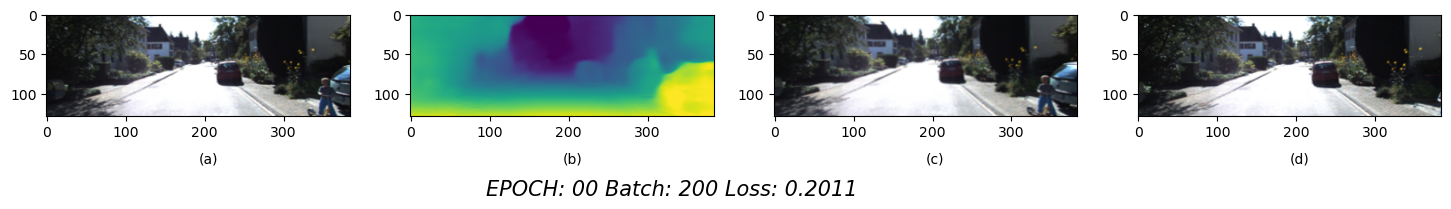

tf.Tensor([-0.00024607 -0.00189711  0.01482879 -0.00142061  0.00292518 -0.00153154], shape=(6,), dtype=float32)
 230/1086 [=====>........................] - ETA: 14:41 - Train_loss: 17.3623

In [ ]:
EPOCHS = 500
if os.path.isfile(os.path.join(model_dir,'train_loss.npy')) and os.path.isfile(os.path.join(model_dir,'val_loss.npy')):
  print('Loading model history .....')
  t_loss =list( np.load(os.path.join(model_dir,'train_loss.npy')))
  v_loss = list(np.load(os.path.join(model_dir,'val_loss.npy')))
  e_his = [i for i in range(len(t_loss))]
  e_init = len(t_loss)
  min_v = v_loss[-1]
else:
  t_loss =[]
  v_loss =[]
  e_his = []
  e_init = 0
print_val = int(1600/batch_size)

total_batches = utils.total_batches(dataset_dir, 'train_set_list.txt', batch_size)
val_batches = utils.total_batches(dataset_dir, 'valid_set_list.txt', batch_size)
metric_name = 'Train loss'

for epoch in range(e_init, EPOCHS):
    if epoch > 99 and epoch %100 == 0:
      print(f'$$$$$ changing learning rate from {lr} to {lr*0.75} $$$$$')
      lr = lr / 2
      optimizer.learning_rate = lr
      #optimizer.learning_rate
    print(f'<<<<<<<<<<< Iniciando Epoch {epoch} >>>>>>>>>>>')

    pb_i = Progbar(total_batches, stateful_metrics=metric_name)
    total_loss = 0.0
    num_batches = 0
    #train_gen = train_gen.take(total_batches)
    #print(total_batches)
    
    
    for batch in train_gen:
      batch_loss, im1, im2, d_map, predictions = distributed_train_step(batch)
      #print(batch_loss, batch[0].shape, tf.reduce_sum(batch[0])/1000000, batch[1][0,:])
      #pred = model(tf.expand_dims(batch[0][0,:,:,:], axis = 0), training = False)
      #print(batch[1][0,:], pred)
      total_loss += batch_loss
      num_batches += 1
      values = [('Train_loss', total_loss/(num_batches))]
      pb_i.update(num_batches, values=values)
      #print(num_batches)
      #print(num_batches)
      if num_batches == 1 or num_batches % (print_val) == 0:
        img_display(epoch, num_batches, loss_map.result(), im1,im2, d_map, predictions)
        print(predictions[0])

    train_loss = total_loss / (num_batches)
    
    print(f'***** Validation epoch: {epoch} *****')


    #val_gen = val_gen.take(val_batches)
    val_batch = 0
    val_loss = 0.0
    pb_i = Progbar(val_batches, stateful_metrics=metric_name)
    for batch in val_gen:
        #print(val_batches)
        batch_loss, im1, im2, d_map, predictions= distributed_test_step(batch)
        val_batch += 1
        val_loss += val_loss
        values = [('Val_loss', val_loss/(val_batch))]
        pb_i.update(val_batch, values=values)
        if val_batch == 1 or val_batch % print_val == 0:
          img_display(epoch, val_batch, val_metrics.result(), im1,im2, d_map, predictions, training=False)
          print(predictions[0])
        
    

    pb_i.update(num_batches, values=[('Train loss',train_loss),('Test loss', val_metrics.result())])
    template = ("Epoch {}, Loss: {}, train_MSE: {}, Test Loss: {}, Test MSE: {}")

    print(template.format(epoch, train_loss, loss_map.result(), val_metrics.result(),
                          val_metrics.result()))
    test_loss = val_metrics.result()
    t_loss.append(loss_map.result())
    v_loss.append(val_metrics.result())
    e_his.append(epoch)
    fname = os.path.join(model_dir,
                         'model-{:02d}-{:.4f}'.format(epoch, test_loss))
    ## TODO Aplicar lr decay
  
    np.save(os.path.join(model_dir,'train_loss.npy'),t_loss)
    np.save(os.path.join(model_dir,'val_loss.npy'),v_loss)
    #model.save_weights(fname + "nip.h5")

    if len(v_loss) >= 2:
        if math.isnan(min_v):
            #model.save_weights(fname + ".h5")
            model.save(fname + ".h5")
            print(f'Saving model... Metric improved from {min_v:.4f} to {v_loss[-1]:.4f}')
            min_v = val_metrics.result()

        if (min_v - v_loss[-1])/min_v >= 0.005:
            #model.save_weights(fname)
            #model.save_weights(fname + ".h5")
            model.save(fname + ".h5")
            print(f'Saving model... Metric improved from {min_v:.4f} to {v_loss[-1]:.4f}')
            min_v = val_metrics.result()
        else:
            print('Model did not improve :(')
    else:
        #model.save_weights(fname)
        #model.save_weights(fname + ".h5")
        model.save(fname + ".h5")
        print(f'Saving model... First update')
        min_v = val_metrics.result()
    
    #val_loss.reset_states()
    loss_map.reset_states()
    val_metrics.reset_states()
    if epoch % 20 == 0:
        utils.plot_hist_list(e_his, t_loss, v_loss, model_dir= model_dir)

utils.plot_hist_list(e_his, t_loss, v_loss, model_dir= model_dir)

In [ ]:
 optimizer.learning_rate

In [ ]:
model.save_weights(fname + ".h5")

In [ ]:
#model.save('model_500')
model = modelos.custom_Res_05((204,204,6))
#model.summary()
model.load_weights('/data/estudiantes/juansoto/Check_nmap_borloss_26_12/weights-133-0.0836.h5')
model.save('/data/estudiantes/juansoto/Check_nmap_borloss_26_12/model-133-0.0836')

In [ ]:
t_loss = list(np.load('/data/estudiantes/juansoto/Check_13_11_sq/train_loss.npy'))
v_loss = list(np.load('/data/estudiantes/juansoto/Check_13_11_sq/val_loss.npy'))
e_his = list(range(len(t_loss)))

model_dir = '/data/estudiantes/juansoto/Check_13_11_sq'
utils.plot_hist_list(e_his, t_loss, v_loss, model_dir= model_dir)



# Predictions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
from keras.models import load_model
import os
import modelos
import argparse
import time
import utils

test_dir = '/data/estudiantes/juansoto/test_folder'
model_folder = '/data/estudiantes/juansoto/Check_nmap_02_12'
seq = '10'
model_name = 'weights-198-0.0937nip'


n=10
# test_tensor, _ = modelos.batch_generator(os.path.join(args.test_dir, args.seq), ('seq_' +args.seq + '_' + 'test_list_p.txt'), 'poses.npy', batch_size = 1)
names_list = utils.text_to_list(os.path.join(os.path.join(test_dir, seq),('seq_' +seq + '_' + 'test_list_p.txt')))
start = time.time()
test_tensor = utils.unpack_images(os.path.join(test_dir, seq),names_list)

gt = np.load(os.path.join(test_dir, seq)+'/poses.npy')

weights_path = os.path.join(model_folder, (model_name+'.h5'))
# model =  load_model(os.path.join(model_folder, (model_name+'.h5')), compile= False)


model = modelos.custom_Res_03((204,204,6))
#model.summary()
model.load_weights(weights_path)
n=len(names_list)
#n=10

results = model.predict(test_tensor)
end = time.time()
# print(results)
print(f'rate: {n/(end-start)} fps')
print(f'Total time: {(end-start)} seconds to process {n} frames')
print(results.shape)

def seq_to_pose(poses, theta_i = 1.559, scale=1, inv= True):
  pose_f = np.zeros((1,6))
  
  i = 0
  idx = 3
  id_theta = 0

  for pose in poses:
    n = np.sqrt((pose[0])**2  + (pose[2])**2) 
    # print(n)
    theta_n = theta_i + pose[5] * scale
    x = -1*n * math.cos(theta_n)
    z = n * math.sin(theta_n)
     
    theta_i = theta_n
    n_x = x + pose_f[i, idx]
    y = pose[idx+1] + pose_f[i,idx+1]
    n_z = z + pose_f[i, idx+2]
    #phi = pose[id_theta+1] + pose_f[i,id_theta+1]
    #beta = pose[id_theta+2] + pose_f[i,id_theta+2]
    phi = 0
    beta = 0
 
    new_pose = np.array([theta_n, phi, beta,n_x, y, n_z]).reshape((1,6))
  
    pose_f = np.append(pose_f, new_pose, axis = 0)
    #print(theta_n)
    i += 1
  # print(pose_f)    
  return pose_f


tp = 'total'
def ATE(gt, preds, tp =tp):
    tr_error = 0
    rot_error = 0
    if tp == 'tras' or tp == 'total':
        tr_error = np.mean(abs(gt[:,3:]-preds[:,0:3]))
    if tp == 'rot' or tp == 'total':
        rot_error = np.mean(abs(gt[:,0:3]-preds[:,3:]))
    total_error = tr_error + rot_error

    return total_error, tr_error, rot_error


tot, tr, rot = ATE(gt, results)
print(f'Total Error: {tot}')
print(f'Tras Error: {tr}')
print(f'Rot Error: {rot}')

# print(f'results: {results[:10,0:3]}')

final_p = seq_to_pose(results)
np.save(os.path.join(model_folder, ('poses_'+ model_name +'_'+ seq + '.npy')), final_p)
# print(f'Final poses: {final_p[:10,0:3]}')

In [ ]:
model_folder = '/data/estudiantes/juansoto/Check_nmap_02_12'
model_name = 'weights-198-0.0937nip'
names_list_t = utils.text_to_list(r'/data/estudiantes/juansoto/dest_folder2/train_set_list.txt')
names_list_v = utils.text_to_list(r'/data/estudiantes/juansoto/dest_folder2/valid_set_list.txt')

names_list = names_list_t +names_list_v
print(len(names_list_t), len(names_list_v), len(names_list))
test_tensor = utils.unpack_images('/data/estudiantes/juansoto/dest_folder2',names_list)
print(names_list[:5])
print(names_list[-5:])

weights_path = os.path.join(model_folder, (model_name+'.h5'))
# model =  load_model(os.path.join(model_folder, (model_name+'.h5')), compile= False)


model = modelos.custom_Res_03((204,204,6))
#model.summary()
model.load_weights(weights_path)
n=len(names_list)
#n=10

results = model.predict(test_tensor)
np.save(os.path.join(model_folder, ('poses_'+ model_name +'_'+ 'train' + '.npy')))

## Visualize

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os


pose_dir = '/data/estudiantes/juansoto/test_folder/'
model_folder = '/data/estudiantes/juansoto/Check_nmap_02_12'
seq = '10'
model_name = 'weights-198-0.0937nip'
predicted_result_dir = os.path.join(model_folder, ('poses_'+ model_name +'_'+ seq + '.npy'))
pose_GT_dir = pose_dir
gradient_color = True

def plot_route(gt, out, c_gt='g', c_out='r'):
	x_idx = 3
	y_idx = 5
	x = [v for v in gt[:, x_idx]]
	y = [v for v in gt[:, y_idx]]
	plt.plot(x, y, color=c_gt, label='Ground Truth', linestyle='--')
	#plt.scatter(x, y, color='b')

	x = [v for v in out[:, x_idx]]
	y = [v for v in out[:, y_idx]]
	plt.plot(x, y, color=c_out, label='DeepVO')
	#plt.scatter(x, y, color='b')
	plt.gca().set_aspect('equal', adjustable='datalim')


def final_pose(poses):
    
    pose_f = [[0, 0, 0, 0, 0, 0]]
    for i in range(len(poses)):
        new_pose = pose_f[i] + poses[i]
        # pose_f = np.append(pose_f, new_pose)
        pose_f.append(new_pose)
    pose_f = np.asarray(pose_f)
    return pose_f


GT_pose_path = os.path.join(pose_GT_dir,(seq + '/poses.npy'))
gt = np.load(GT_pose_path)
w = gt
gt = final_pose(gt)
out = np.load(predicted_result_dir)



theta = 150 * math.pi/180

z=2
x=0
#out[:,x] = out[:,x] * math.cos(theta) - out[:,z] * math.sin(theta) 
#out[:,z] = out[:,x] * math.sin(theta) + out[:,z] * math.cos(theta)

# out[:,x] = out[:,x] * 5
# out[:,z] = out[:,z] * 7

# print(out[0:5,])
# print(out.shape)
mse_rotate = 100 * np.mean((out[:, 3:] - gt[:, :3])**2)
mse_translate = np.mean((out[:, :3] - gt[:, 3:6])**2)
print('mse_rotate: ', mse_rotate)
print('mse_translate: ', mse_translate)


if gradient_color:
	# plot gradient color
	step = 200
	plt.clf()
	plt.scatter([gt[0][3]], [gt[0][5]], label='sequence start', marker='s', color='k')
	for st in range(0, len(out), step):
		end = st + step
		g = max(0.2, st/len(out))
		c_gt = (0, g, 0)
		c_out = (1, g, 0)
		plot_route(gt[st:end], out[st:end], c_gt, c_out)
		if st == 0:
			plt.legend()
		plt.title('Sequence' + seq)
		save_name = '{}route_{}_gradient.png'.format((model_name), seq)
	plt.savefig(os.path.join(model_folder,save_name))
else:
	# plot one color
	plt.clf()
	plt.scatter([gt[0][3]], [gt[0][5]], label='sequence start', marker='s', color='k')
	plot_route(gt, out, 'r', 'b')
	plt.legend()
	plt.title('Sequence' + seq)
	save_name = '{}route_{}.png'.format(model_name, seq)
	plt.savefig(os.path.join(model_folder,save_name))


## Check Predictions

In [ ]:
from random import randrange, randint

In [ ]:
n = 10
l = len(names_list)

r_index = [randint(0, l) for p in range(0, n)]
print(r_index)

In [ ]:
print(test_tensor[0].shape)
model_dir = '/data/estudiantes/juansoto/Check_13_11_sq'

In [ ]:
def test_step_display(images, model):
  
  images = tf.expand_dims(images, axis = 0)
  im1 = utils.std_img(images[:,:,:,:3])
  im2 = utils.std_img(images[:,:,:,3:])
  predictions = model(images, training=False)
  
  t_loss, imr = compute_loss(im2, im1, predictions)
  

  return t_loss, im1, im2, predictions

In [ ]:
for i in r_index:
    batch_loss, im1, im2, predictions= test_step_display(test_tensor[i], model)

    
    img_display(None, names_list[i],batch_loss, im1,im2, predictions, training=False, checking = True)
    print(predictions)